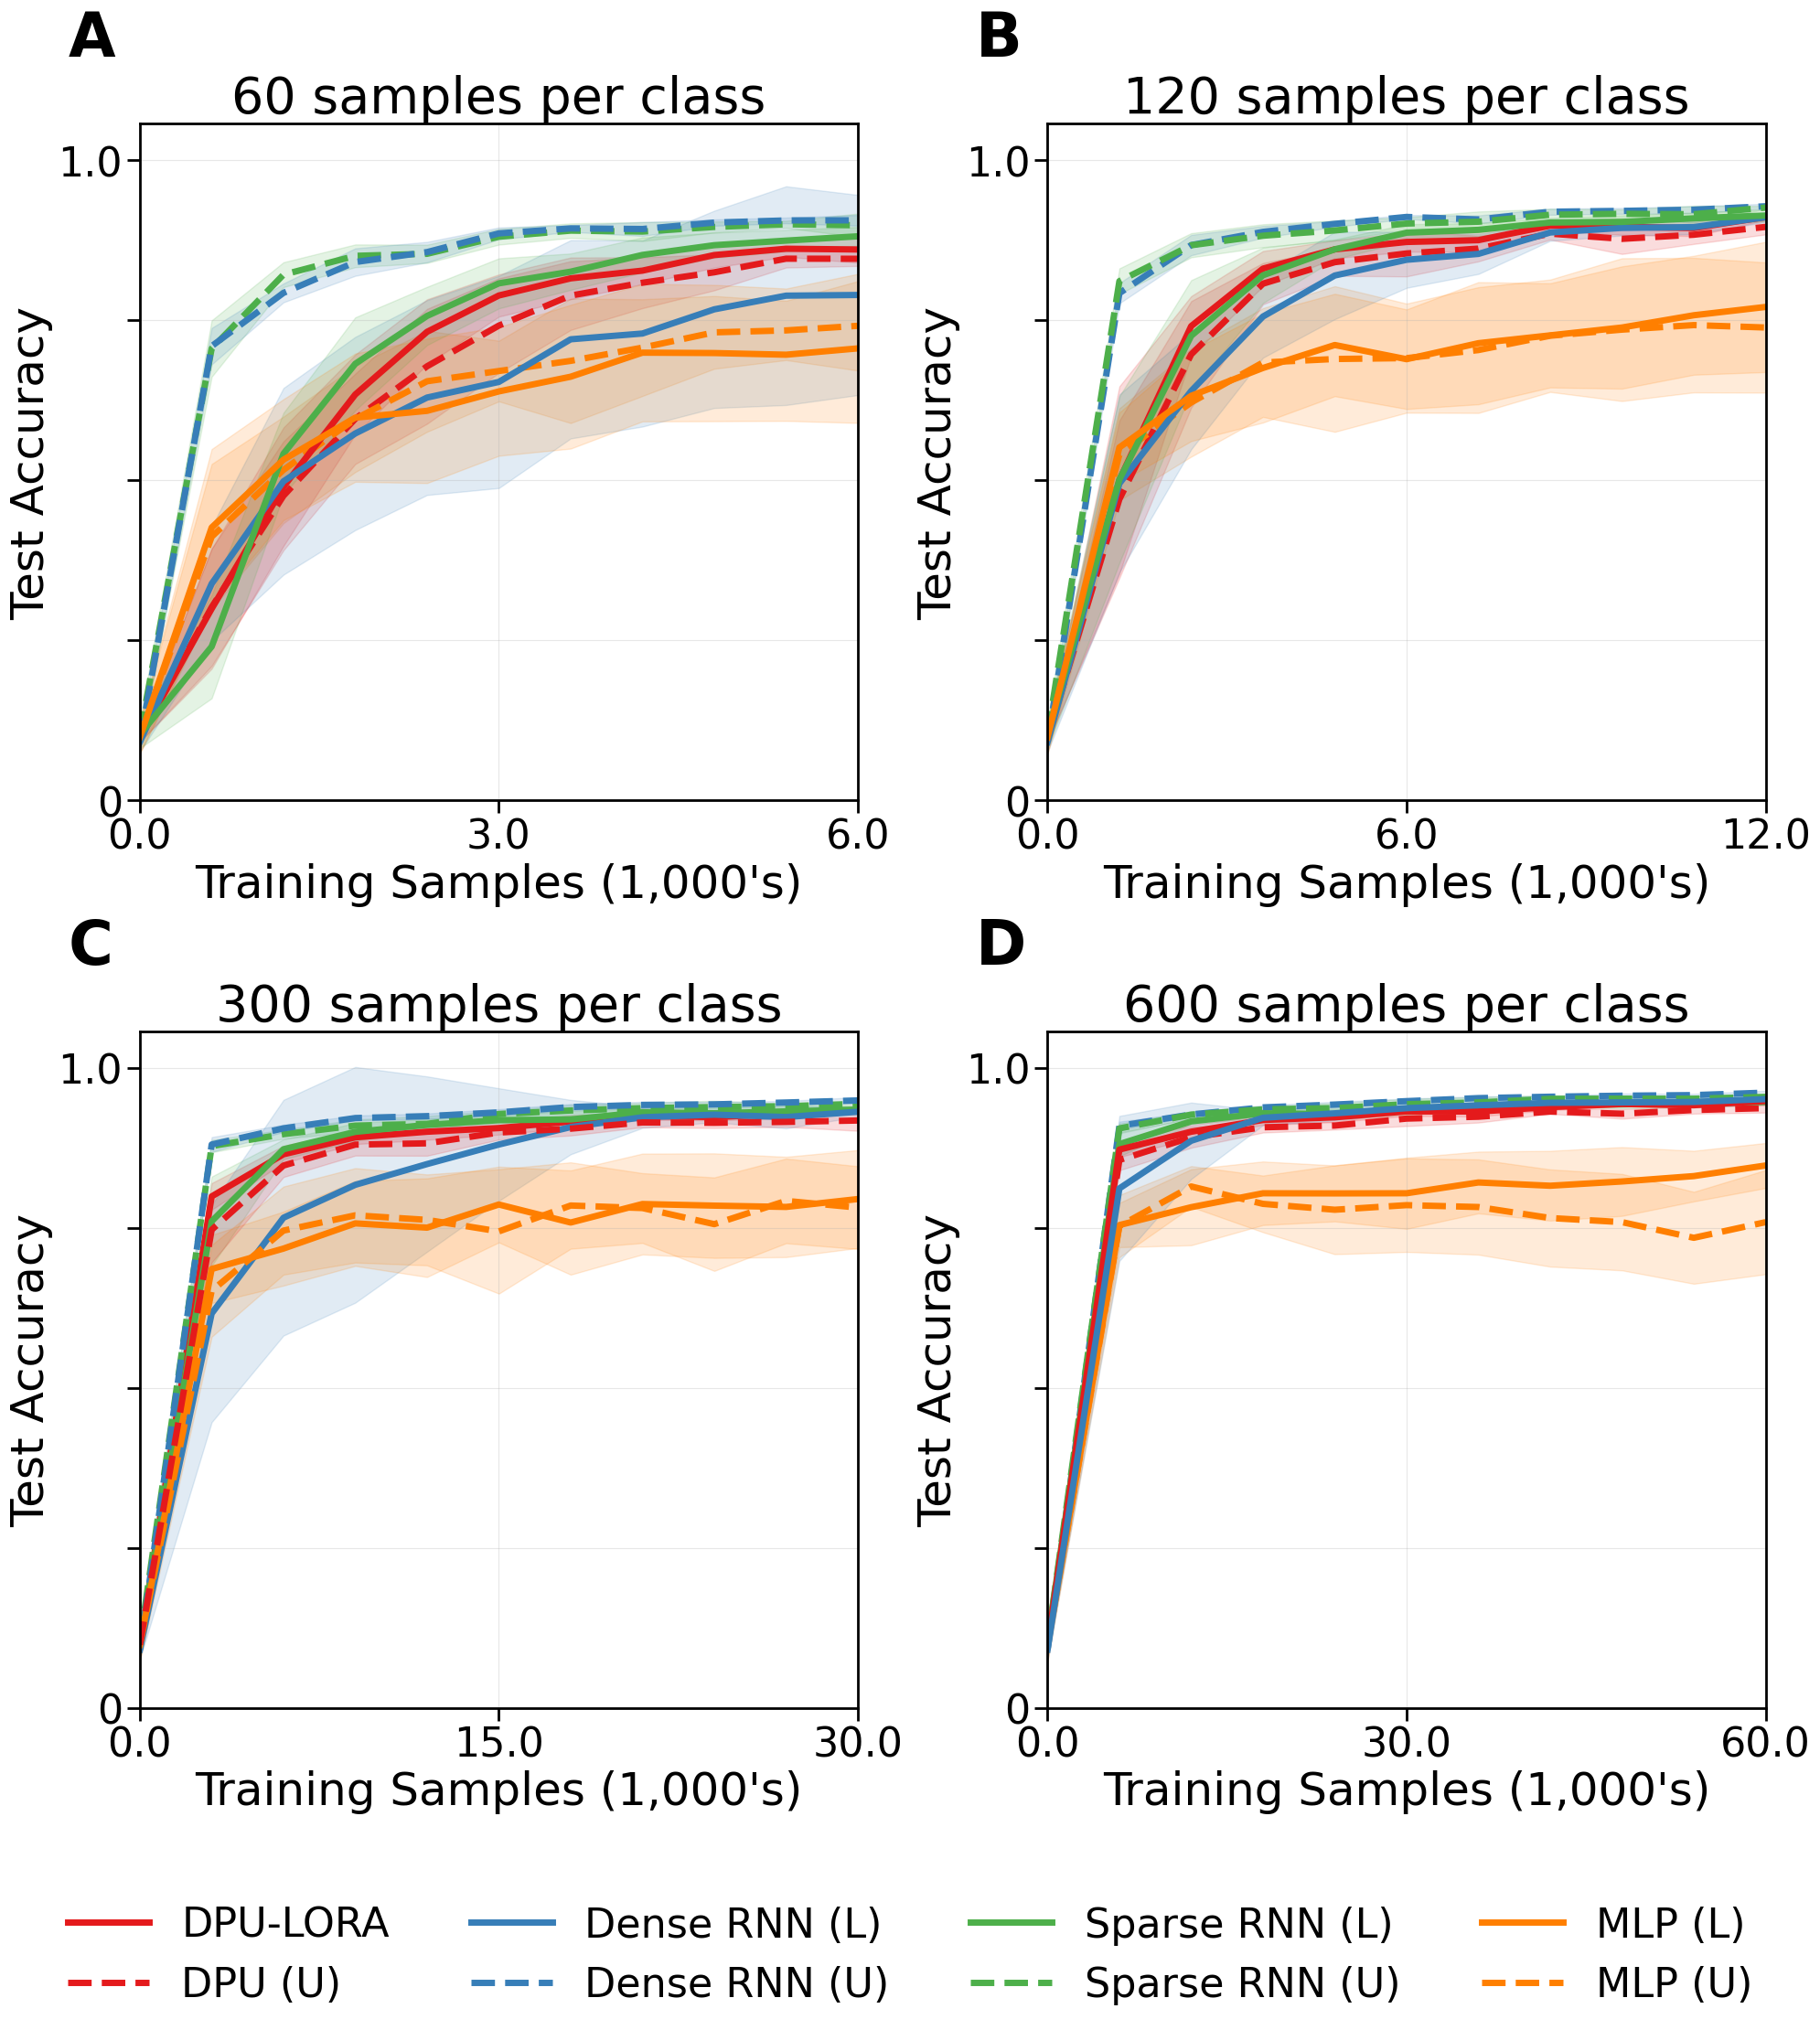

In [6]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

RESULTS_DIR = "../results/"
SELECTED_SAMPLES = ["1%", "2%", "5%", "10%"]  # List of samples to plot

COLOR_MAP = {
    "DPU_LoRA": "#E41A1C",
    "Unlearnable_DPU": "#E41A1C",
    "Learnable_RNN_No_Sparsity": "#377EB8",
    "Unlearnable_RNN_No_Sparsity": "#377EB8",
    "Learnable_RNN_Same_Sparsity": "#4DAF4A", 
    "Unlearnable_RNN_Same_Sparsity": "#4DAF4A",
    "Unlearnable_SIO_DPU": "#F781BF",
    "Unlearnable_Threehidden_MLP": "#FF7F00",
    "Learnable_Threehidden_MLP": "#FF7F00"
}

LINE_STYLE = {
    "DPU_LoRA": "-",
    "Unlearnable_DPU": "--",
    "Learnable_RNN_No_Sparsity": "-",
    "Unlearnable_RNN_No_Sparsity": "--",
    "Learnable_RNN_Same_Sparsity": "-",
    "Unlearnable_RNN_Same_Sparsity": "--",
    "Learnable_RNN_Same_Sparsity_Level": "-",
    "Unlearnable_RNN_Same_Sparsity_Level": "--",
    "Learnable_Threehidden_MLP": "-",
    "Unlearnable_Threehidden_MLP": "--",
    "Unlearnable_SIO_DPU": "--",
}

def load_results(selected_sample):
    target_samples = {"1%":60, "2%":120, "5%":300, "10%":600}[selected_sample]
  
    data = {}
    pattern = re.compile(r"^(?P<exp>\w+?)(_fewshot_\d+)?(_trial\d+)?(\.signed)?\.pkl$")
  
    for fname in os.listdir(RESULTS_DIR):
        match = pattern.match(fname)
        if not match: continue
      
        exp_name = match.group("exp")
        if "_fewshot" in fname:
            samples = int(fname.split("_fewshot_")[1].split("_")[0])
            if samples != target_samples: continue
        else:
            continue
      
        try:
            with open(os.path.join(RESULTS_DIR, fname), "rb") as f:
                results = pickle.load(f)
                if 'epoch_test_acc' in results:
                    key = (exp_name, "learnable" if "Learnable" in exp_name else "unlearnable")
                    data.setdefault(key, []).append(results['epoch_test_acc'])
        except Exception as e:
            print(f"Error loading {fname}: {e}")
            continue
  
    return data

def create_custom_legend():
    legend_elements = [
        Line2D([0], [0], color=COLOR_MAP["DPU_LoRA"], ls="-", lw=5.0, label="DPU-LORA"),
        Line2D([0], [0], color=COLOR_MAP["Unlearnable_DPU"], ls="--", lw=5.0, label="DPU (U)"),
        Line2D([0], [0], color=COLOR_MAP["Learnable_RNN_No_Sparsity"], ls="-", lw=5.0, label="Dense RNN (L)"),
        Line2D([0], [0], color=COLOR_MAP["Learnable_RNN_No_Sparsity"], ls="--", lw=5.0, label="Dense RNN (U)"),
        Line2D([0], [0], color=COLOR_MAP["Learnable_RNN_Same_Sparsity"], ls="-", lw=5.0, label="Sparse RNN (L)"),
        Line2D([0], [0], color=COLOR_MAP["Learnable_RNN_Same_Sparsity"], ls="--", lw=5.0, label="Sparse RNN (U)"),
        Line2D([0], [0], color=COLOR_MAP["Learnable_Threehidden_MLP"], ls="-", lw=5.0, label="MLP (L)"),
        Line2D([0], [0], color=COLOR_MAP["Unlearnable_Threehidden_MLP"], ls="--", lw=5.0, label="MLP (U)"),
    ]
    return legend_elements

def plot_results(data, ax, selected_sample, global_y_max):
    x_max = 0
    max_acc = 0
    
    for (exp_name, _), acc_list in data.items():
        if exp_name not in COLOR_MAP or exp_name not in LINE_STYLE:
            continue
            
        acc_matrix = np.array(acc_list)
        epochs = acc_matrix.shape[1]
      
        mean = np.mean(acc_matrix, axis=0)
        std = np.std(acc_matrix, axis=0, ddof=1)
        max_acc = max(max_acc, np.max(mean))
      
        target_samples = {"1%":60, "2%":120, "5%":300, "10%":600}[selected_sample]
        x = np.arange(epochs) * target_samples * 10 / 1000  # Convert to thousands
        x_max = max(x_max, x[-1])
      
        ax.plot(
            x, mean,
            color=COLOR_MAP[exp_name],
            linestyle=LINE_STYLE[exp_name],
            linewidth=5.0
        )
      
        ax.fill_between(
            x, mean - std, mean + std,
            color=COLOR_MAP[exp_name],
            alpha=0.15
        )
    
    # Set y-axis ticks
    y_ticks = [0, 0.25, 0.5, 0.75, 1.0]
    y_labels = [0, "", "", "", 1.0]
    
    # Use global max for y-axis scaling
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, fontsize=32)
    
    # Set x-axis ticks
    x_ticks = [0, x_max/2, x_max]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f"{x:.1f}" for x in x_ticks], fontsize=32)
    
    # Set labels and title
    ax.set_xlabel("Training Samples (1,000's)", fontsize=36)
    ax.set_ylabel("Test Accuracy", fontsize=36)
    samples_per_class = {"1%":60, "2%":120, "5%":300, "10%":600}[selected_sample]
    ax.set_title(f"{samples_per_class} samples per class", fontsize=40)
    
    # Set limits and grid
    ax.set_xlim(0, x_max*1.0)
    ax.set_ylim(0, global_y_max)
    ax.grid(True, alpha=0.3)
    
    # Make tick marks thicker
    ax.tick_params(width=2, length=10)
    
    return max_acc

if __name__ == "__main__":
    # Create a 2x2 subplot figure
    plt.rcParams['axes.linewidth'] = 2.0  # Make all axis lines thicker
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    axes = axes.flatten()
    
    # First, collect all data and determine global max y-value
    all_data = {}
    global_max_acc = 0
    
    for sample in SELECTED_SAMPLES:
        experiment_data = load_results(sample)
        all_data[sample] = experiment_data
        
        # Find max accuracy across all panels
        for (exp_name, _), acc_list in experiment_data.items():
            if exp_name not in COLOR_MAP or exp_name not in LINE_STYLE:
                continue
            acc_matrix = np.array(acc_list)
            mean = np.mean(acc_matrix, axis=0)
            global_max_acc = max(global_max_acc, np.max(mean))
    
    # Use a consistent y-axis scaling with a bit of padding
    global_y_max = max(1.0, global_max_acc * 1.1)
    
    # Add panel labels
    panel_labels = ['A', 'B', 'C', 'D']
    for ax, label in zip(axes, panel_labels):
        ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=48, fontweight='bold')
    
    # Plot each panel with consistent y-axis scaling
    for idx, sample in enumerate(SELECTED_SAMPLES):
        plot_results(all_data[sample], axes[idx], sample, global_y_max)
    
    # Add legend to the bottom of the figure
    legend = fig.legend(
        handles=create_custom_legend(),
        loc="center",
        bbox_to_anchor=(0.5, -0.07),
        ncol=4,
        frameon=False,
        fontsize=32,
        # handlelength=3,
        # handleheight=3,
    )
    
    plt.tight_layout()
    plt.savefig("./figures/performance_curve.pdf", bbox_inches="tight")
    plt.show()